### GOAL

In this notebook we are attempting to build a simple disentanglement model using BART encoder and decoder.
1. Two encoders:
  - A context encoder: to extract the semantic and context of toxic text.
  - A masked encoder: completely remove offensive texts and replace them with masked tokens as input text, this encoder is represented for preliminary non-toxic style encoding. 
2. Decoder: using cross attention between the masked encoder and the context encoder as input to the decoder to transfer toxic texts to non-toxic texts. 

### DISCLAIMER :  
Due to nature of experiment the notebook contains profanity and toxic words. Please proceed with caution. 

## 1. Setup

### 1.1. Libraries and Helper Functions

In [1]:
!pip install transformers --quiet
!pip install tqdm boto3 requests regex sentencepiece sacremoses evaluate --quiet
!pip install rouge --quiet
!pip install better_profanity --quiet
!pip install rouge-score --quiet
!pip install -U evaluate --quiet

Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.nn.utils.rnn import pad_sequence

from transformers import BartTokenizer, BartConfig, BartForConditionalGeneration,BartModel,AutoTokenizer
from transformers import AdamW, get_cosine_schedule_with_warmup
from rouge import Rouge 
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import evaluate
from better_profanity import profanity

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import datetime
import string
import regex as re
# upload external file before import
# from google.colab import files
# from google.colab import drive


In [4]:
# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%cd ..
# cd drive/MyDrive/w266/style_transfer_w266/

/home/ubuntu/style_transfer_w266


In [7]:
train_path='data/original-train.tsv'
dev_path='data/original-dev.tsv'
test_path='data/original-test.tsv'
# train_path='/content/drive/MyDrive/Colab Notebooks/data/original-train.tsv'
# dev_path='/content/drive/MyDrive/Colab Notebooks/data/original-dev.tsv'
# test_path='/content/drive/MyDrive/Colab Notebooks/data/original-test.tsv'

In [8]:
train=pd.read_csv(train_path,sep="\t", header=0)
dev=pd.read_csv(dev_path,sep="\t", header=0) 
test=pd.read_csv(test_path,sep="\t", header=0) 
display(train[1:])

,offensive-text,style-transferred-text
1,"Ok, this makes no sense. This will create vigi...","Ok, this makes no sense. This will create vigi..."
2,so fucking true. the amount of up and coming r...,so true. the amount of up and coming rappers t...
3,Go f yourself Republican scum who put us here ...,Republicans put us in this situation. I would ...
4,Dumb fucking take. People want to do things.,That's not a smart take. People want to do thi...
5,Fuck no 😂,no
...,...,...
1579,The View! And this crap hits my front page!? l...,"This must be mostly bots but still, it's stran..."
1580,That’s racist.,Those actions are racist.
1581,Cultural Marxism isn't a thing you weird fuck.,Cultural Marxism isn't a thing.
1582,"LOL, anyone that questions the Democrat progra...","LOL, anyone that questions the Democrat progra..."


In [9]:
train['offensive-text'].str.len().max()

238

In [10]:
train['offensive-text'].str.len().min()

9

In [11]:
train['offensive-text'].str.len().mean()

69.85353535353535

In [12]:
train[train['style-transferred-text']=='']

,offensive-text,style-transferred-text


In [13]:
def clean_up_text(x):
  """Remove line breaks, special characters, within each post"""
  # Remove special characters and punctuations
  SPECIAL_CHARS_PATTERN = re.compile(r"(\*)|(\~)|(\=)|(\.\.\.)|(\;)|(\:)|(\’)|(\_)|(\-)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\\)|(\{)|(\})")
  x = SPECIAL_CHARS_PATTERN.sub("", x)

  # Remove different types of line breaks and white spaces
  x = re.sub(r"\n|\r|\r\n|<br\s*/?>", " ", x)
  
  # Remove extra white spaces
  x = re.sub(r"\s+", " ", x.strip())

  return x

In [14]:
def read_process_data(df):
    # df["offensive-text"] = df["offensive-text"].str.lower()
    # df["offensive-text"] = df["offensive-text"].str.replace(rf"([{string.punctuation}])+"," ", regex=True)
    df["offensive-text"] = df["offensive-text"].apply(clean_up_text)
    df["offensive-text"] = df["offensive-text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ") #\n|\r|\r\n|

    # df["style-transferred-text"] = df["style-transferred-text"].str.lower()
    # df["style-transferred-text"] = df["style-transferred-text"].str.replace(rf"([{string.punctuation}])+"," ", regex=True)
    df["style-transferred-text"] = df["style-transferred-text"].apply(clean_up_text)
    df["style-transferred-text"] = df["style-transferred-text"].str.replace("\xa0", " ", regex=False).str.split().str.join(" ")
  
    df['offensive-text']=df['offensive-text'].astype(str).apply(lambda x: x.encode('latin-1', 'ignore').decode('latin-1'))
    df["style-transferred-text"] = df["style-transferred-text"].astype(str).apply(lambda x: x.encode('latin-1', 'ignore').decode('latin-1'))

    print('The null count :: ',df.isnull().sum())
    return df

In [15]:
# PASS PROCESS "True" TO CREATE CLEANED DATASET : ONE TIME EFFORT
def cleaned_data(process=False):
  if process:
    x=read_process_data(train)
    x.to_csv('data/clean_train.csv', header = False)
    z=read_process_data(test)
    z.to_csv('data/clean_test.csv', header = False)
    y=read_process_data(dev)
    y.to_csv('data/clean_dev.csv', header = False)

cleaned_data(process=True)

The null count ::  offensive-text            0
style-transferred-text    0
dtype: int64
The null count ::  offensive-text            0
style-transferred-text    0
dtype: int64
The null count ::  offensive-text            0
style-transferred-text    0
dtype: int64


In [88]:
train_path='data/clean_train.csv'
dev_path='data/clean_dev.csv'
test_path='data/clean_test.csv'

def format_time(seconds):
    return str(datetime.timedelta(seconds=int(round(seconds))))

Below code is implementation of BART (Bidirectional and Auto-Regressive Transformer) model for sequence-to-sequence (seq2seq) tasks using PyTorch. The BART model is a variant of the Transformer model and is pre-trained on a large corpus of text data using a denoising autoencoder objective. It is capable of generating high-quality text with coherent sentence structures.

The code defines a PyTorch Dataset class MyDataset that reads the input and target text sequences from a text file and tokenizes them using the BART tokenizer. It then defines the collate_fn function to pad the sequences in each batch to the same length. The code then defines the BartEncoderDecoder class, which is the main model class that uses the BART encoder and decoder architecture.

The code instantiates the BART tokenizer and the BartEncoderDecoder model, and loads the training and validation data using the MyDataset class. It also defines the optimizer and loss function. The code then runs the training loop for a specified number of epochs, during which it trains the model on the training set and evaluates it on the validation set.

During training, the code iterates over the batches of training data and performs forward and backward passes through the model to compute the loss and update the model parameters using the Adam optimizer. The code also implements gradient accumulation by accumulating the gradients over a specified number of batches to reduce the memory requirements during training. After training on all the batches, the code computes the average loss over the entire training set and evaluates the model on the validation set.

During validation, the code iterates over the batches of validation data and generates the predicted text sequences using the generate method of the BART decoder. It then computes the loss between the predicted and target sequences and accumulates the loss over all the batches to compute the average loss over the entire validation set. Finally, the code prints the average training and validation loss for each epoch.

In [89]:
#uncomment if memory issue happens. This will free up some space
torch.cuda.empty_cache()

## Training BART Disentanglement Model

1. Used tokenizer = "facebook/bart-base" based on available resources

2. To mask profanity words used better_profanity python package and along with this used BADWORD custom list to mask toxic words.

3. Limited Batch size to 16 max as training dataset has 1584 records. Also used low number of epochs.

4. We had a choice to use decoder.generate() or decoder.outputs() to get generated token ids. We will be using generate method. torch.argmax(outputs.logits, dim=-1) gives the index of the highest logit value for each position in the output sequence. This is not the same as the sequence of generated IDs produced by decoder.generate(), because decoder.generate() applies several additional steps during decoding, such as beam search and top-k sampling, that are not present in a simple argmax operation.
The decoder.generate() method in BART uses beam search to generate multiple possible sequences, and then returns the highest-scoring sequence according to a scoring function that takes into account both the log-likelihood of the sequence and various penalties for things like repeated n-grams. This process is more complex than simply taking the argmax of the logits, and can lead to better quality generated sequences.

In [19]:
# Test profanity library output
toxic_seq = ' NTA.   Dump his ASS. Tablemanners are no rocket science. Treating other people like human beings is no rocket science. His still a child.'
censored_text = profanity.censor(toxic_seq)
print(censored_text)
masked_toxic_seq=censored_text.replace('****','<mask>')
print(masked_toxic_seq)

 NTA.   Dump his ****. Tablemanners are no rocket science. Treating other people like human beings is no rocket science. His still a child.
 NTA.   Dump his <mask>. Tablemanners are no rocket science. Treating other people like human beings is no rocket science. His still a child.


In [20]:
# Test profanity library output
toxic_seq = 'I wish you a major accident and a painful stroke, there is no good reason for you to exist. I will be very happy to attend your funeral'
censored_text = profanity.censor(toxic_seq)
print(censored_text)
masked_toxic_seq=censored_text.replace('****','<mask>')
print(masked_toxic_seq)

I wish you a major accident and a painful ****, there is no good reason for you to exist. I will be very happy to attend your funeral
I wish you a major accident and a painful <mask>, there is no good reason for you to exist. I will be very happy to attend your funeral


In [90]:
# Instantiate BART tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base') 

profanity.load_censor_words()
BADWORDS = ['suck','stupid','pimp','dumb','homo','slut','damn','ass','rape','poop','cock','lol','crap','sex','nazi','neo-nazi',
    'fuck','bitch','pussy','penis','vagina','whore','shit','nigger','nigga','cocksucker','assrape','motherfucker','wanker','cunt', 'evil',
    'faggot','fags','asshole','piss','cum','moron','cuckold','shit','filthy','retarded','screw','cucked','lick','lmfao','tf', 'dump', 'assholes'
]

class MyDataset(Dataset):
    """
    this class generate tokens of input, masked and target sentences 
    data_path: The path to the training data file.
    max_seq_len: The maximum sequence length allowed for the input sequences.
    kind : contains value like training, validation etc . This is used to print the token generation of phases like training , validation or testing

    In the __init__ method, the training data is loaded from the specified file, and each line of text is stored in a list.
    In the __len__ method, the length of the dataset is returned (i.e., the number of lines in the training data file).
    In the __getitem__ method, an individual training example is retrieved based on the specified index. 
                              The input text is tokenized using the specified tokenizer and truncated to the specified maximum sequence length, 
                              and the resulting token ids are converted to a PyTorch tensor and returned as the training example.
    """
    def __init__(self, data_path, max_seq_len,kind):
        
        self.max_seq_len = max_seq_len

        self.toxic_ids = []
        self.non_toxic_ids = []
        self.masked_toxic_ids=[]

        c=0
        with open(data_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split(',')
                    toxic_seq = parts[1]
                    non_toxic_seq = parts[2]

                    # Replace profanity and badwords with <mask> token
                    censored_text = profanity.censor(toxic_seq)
                    masked_toxic_seq=censored_text.replace('****','<mask>')

                    for words in BADWORDS:
                      masked_toxic_seq=masked_toxic_seq.replace(words,'<mask>')
                      masked_toxic_seq=masked_toxic_seq.replace(words.upper(),'<mask>')
                      masked_toxic_seq=masked_toxic_seq.replace(words.title(),'<mask>')

                    toxic_ids = tokenizer(toxic_seq, max_length=max_seq_len,padding="max_length", truncation=True)
                    non_toxic_ids = tokenizer(non_toxic_seq, max_length=max_seq_len,padding="max_length", truncation=True)
                    masked_toxic_ids= tokenizer(masked_toxic_seq, max_length=max_seq_len,padding="max_length", truncation=True)
                    
                    self.toxic_ids.append(toxic_ids.input_ids)
                    self.non_toxic_ids.append(non_toxic_ids.input_ids)
                    self.masked_toxic_ids.append(masked_toxic_ids.input_ids)

                    if c==0:
                      print('\n',kind,' dataset preview .....')
                      print('*******************************************')
                      print('Input :: toxic        ::',toxic_seq)
                      print('Input :: masked toxic ::',masked_toxic_seq)
                      print('Input :: non toxic    ::',non_toxic_seq)
                      print('encoded length toxic :',toxic_ids)
                      print('encoded length masked toxic: ',masked_toxic_ids)
                      print('encoded length non toxic: ',non_toxic_ids)
                      print('*******************************************')
                    c=c+1
            print('total number of',kind,' data processed : ',c)

    def __len__(self):
        return len(self.toxic_ids)

    def __getitem__(self, index):
        toxic_ids = self.toxic_ids[index]
        non_toxic_ids = self.non_toxic_ids[index]
        masked_toxic_ids =self.masked_toxic_ids[index]

        # Create a PyTorch tensor from the tokenized sequences
        toxic_ids = torch.tensor(toxic_ids, dtype=torch.int64)
        non_toxic_ids = torch.tensor(non_toxic_ids, dtype=torch.int64)
        masked_toxic_ids = torch.tensor(masked_toxic_ids, dtype=torch.int64)

        return {'toxic_ids': toxic_ids, 'non_toxic_ids': non_toxic_ids, 'masked_toxic_ids': masked_toxic_ids}


In [91]:
# Define hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 4
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
MAX_SEQ_LEN = 256
D_MODEL = 256 # dimensionality of the input and output vectors of the Transformer model. It is also commonly referred to as the "hidden size" of the model.POWER OF 2
NUM_HEADS = 4 #number of attention heads used in multi-head attention (D_MODEL/NUM_HEADS=INT)
NUM_ENCODER_LAYERS = 4 
NUM_DECODER_LAYERS = 4 
DIM_FEEDFORWARD = 1024 #(4 times of D_MODEL)
DROPOUT = 0.3
GRADIENT_ACCUMULATION_STEPS = 2 # accumulate gradients over 2 batches
HIDDEN_SIZE = 768

# Define BART encoder-decoder model
class BartEncoderDecoder(nn.Module):
    def __init__(self, bart_config):
        super().__init__()

        self.context_encoder = BartModel.from_pretrained('facebook/bart-base') #The bare BART Model outputting raw hidden-states without any specific head on top.
        self.context_encoder.config = bart_config
        self.masked_encoder_decoder = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
        self.masked_encoder_decoder.config = bart_config
        self.bart_config=bart_config
       
    def forward(self, context_input_ids, masked_input_ids, target_ids=None):

        # Generate hidden representations for the input sequence using the encoder
        context_encoder_outputs = self.context_encoder(input_ids=context_input_ids).encoder_last_hidden_state
        
        # Pass the modified input sequence as input to the decoder, target sequence as label, encoder outputs (all layers) and generate the output sequence
        # Cross attention between context encoder output and masked encoder output
        decoder_outputs = self.masked_encoder_decoder(input_ids=masked_input_ids, encoder_outputs=context_encoder_outputs, 
                                       labels=target_ids) 
        return decoder_outputs


In [92]:
# Instantiate BART encoder-decoder model
bart_config = BartConfig(d_model=D_MODEL, encoder_layers=NUM_ENCODER_LAYERS, decoder_layers=NUM_DECODER_LAYERS, 
                         encoder_attention_heads=NUM_HEADS, decoder_attention_heads=NUM_HEADS,
                         encoder_ffn_dim=DIM_FEEDFORWARD, decoder_ffn_dim=DIM_FEEDFORWARD, dropout=DROPOUT, hidden_size=HIDDEN_SIZE) 
bart_model = BartEncoderDecoder(bart_config).cuda() # move the model to CUDA

In [93]:
def loss_fn(outputs, targets):
    """
    This is loss function return cross entropy between decoder output and target tokens
    """
    batch_size, seq_len, vocab_size = outputs.logits.shape
    outputs = outputs.logits.view(batch_size * seq_len, vocab_size)
    
    # Reshape the targets tensor to (batch_size * seq_len)
    targets = targets.view(-1)
    loss = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)(outputs, targets)
    return loss

def collate_fn(batch, batch_size=BATCH_SIZE):
    """
    This function is used to pad and make all input sentences of batch of equal sizes 
    """
    # Pad sequences in batch to have the same length
    toxic_ids = pad_sequence([item['toxic_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    masked_toxic_ids = pad_sequence([item['masked_toxic_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    non_toxic_ids = pad_sequence([item['non_toxic_ids'] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)

    # Split data into batches of the desired size
    num_batches = len(batch) // batch_size
    if len(batch) % batch_size != 0:
        num_batches += 1
    toxic_batches = list(torch.split(toxic_ids[:num_batches*batch_size], batch_size))
    masked_toxic_batches = list(torch.split(masked_toxic_ids[:num_batches*batch_size], batch_size))
    non_toxic_batches = list(torch.split(non_toxic_ids[:num_batches*batch_size], batch_size))

    # Pad the last batch to ensure that all batches have the same size
    if len(toxic_batches[-1]) < batch_size:
        toxic_batches[-1] = nn.functional.pad(toxic_batches[-1], (0, 0, 0, batch_size - len(toxic_batches[-1])), value=tokenizer.pad_token_id)
        masked_toxic_batches[-1] = nn.functional.pad(masked_toxic_batches[-1], (0, 0, 0, batch_size - len(masked_toxic_batches[-1])), value=tokenizer.pad_token_id)
        non_toxic_batches[-1] = nn.functional.pad(non_toxic_batches[-1], (0, 0, 0, batch_size - len(non_toxic_batches[-1])), value=tokenizer.pad_token_id)

    return [{'toxic_ids': t, 'non_toxic_ids': nt,'masked_toxic_ids': mt} for t, nt, mt in zip(toxic_batches, non_toxic_batches,masked_toxic_batches)][0]

In [25]:
bart_model

BartEncoderDecoder(
  (context_encoder): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05,

In [94]:
import torch.autograd as autograd

def train(train_loader, epoch, learning_rate=LEARNING_RATE, epochs=NUM_EPOCHS, verbose=True, batch_size=BATCH_SIZE):
  """
  This function is for training the model with forced learning at decoder side. 
  The encoder recieves input toxic sequence and decoder gets masked toxic sentence and target sequences.
  """
  autograd.set_detect_anomaly(True)

  # Instantiate optimizer and loss function
  # train_losses=[]
  
  # print('\nTokenizer information :: ')
  # print('eos_token_id :',tokenizer.eos_token_id)
  # print('pad_token_id :',tokenizer.pad_token_id)
  # print('bos_token_id :', tokenizer.bos_token_id)
  # print('sep_token_id :', tokenizer.sep_token_id,'\n')

  # start time
  t0 = time.time()

  # Training loop
  # for epoch in range(epochs):
  #     print ('######  Epoch {}/{} ######'.format(epoch+1, epochs))
      
  # Train the model
  bart_model.train()
  train_loss = 0
  epoch_loss=0

  for step, batch in enumerate(train_loader):
      src = batch['toxic_ids'].cuda()
      tgt = batch['non_toxic_ids'].cuda()
      masked_src=batch['masked_toxic_ids'].cuda()

      optimizer.zero_grad()
      outputs=bart_model(context_input_ids=src, masked_input_ids=masked_src, target_ids=tgt)

      loss = outputs.loss
      # loss = loss_fn(outputs, tgt.cuda())
      # loss = loss.mean() # reduce the loss tensor to a scalar tensor by taking the mean
      # loss /= GRADIENT_ACCUMULATION_STEPS

      loss.backward()
      # if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()

      epoch_loss += loss.item()

      # Report progress every 10 batches
      if verbose and step % 10 == 0:
          print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}'.format(epoch+1, epochs, step+1, len(train_loader), loss.item()))

  avg_loss = epoch_loss / len(train_loader)
  # train_losses.append(avg_loss)

  elapsed_time = time.time() - t0
  if verbose:
      print('Epoch [{}/{}], Average Train Loss: {:.4f}, Elapsed Time: {}'.format(epoch+1, epochs, avg_loss, format_time(elapsed_time)))

  # return train_losses, sum(train_losses) / len(train_losses)
  return avg_loss

In [95]:
rouge = evaluate.load('rouge')

def get_max_length(input_sequence):
    # Return a multiple of the input sequence length as the maximum length
    return int(len(input_sequence) * 1.75)

def get_min_length(input_sequence):
    # Return a multiple of the input sequence length as the maximum length
    return int(len(input_sequence))

def validate(val_loader, epoch, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE, optimizer_type='Adam', epochs=NUM_EPOCHS,verbose=True):
    """
    Function to perform validation cycle on data loader and generate sentences
    """

    bart_model.eval()
    
    # total_tokens = 0
    # val_losses=[]
    generated_texts = []
    gold_texts = []
    t0 = time.time()

    with torch.no_grad():
      # for epoch in range(epochs):
      #   print ('######  Epoch {}/{} ######'.format(epoch+1, epochs))
      epoch_loss=0
      for step,batch in enumerate(val_loader):
          src = batch['toxic_ids'].cuda()
          tgt = batch['non_toxic_ids'].cuda()
          masked_src=batch['masked_toxic_ids'].cuda()

          outputs=bart_model(context_input_ids=src, masked_input_ids=masked_src, target_ids=tgt)

          loss = outputs.loss
          # loss = loss_fn(outputs, tgt.cuda())         
          epoch_loss += loss.item()
      
          # generate style transfer
          generated_ids = bart_model.masked_encoder_decoder.generate(
              input_ids=masked_src.cuda(),
              # max_length=get_max_length(masked_src.cuda()),
              max_length=256,
              min_length=get_min_length(tgt.cuda()),
              num_beams=5,
              early_stopping=True,
              top_k=50, 
              length_penalty=2, #1.2
              repetition_penalty=1,
              no_repeat_ngram_size=5,
              top_p = 0.95,
              temperature=0.8,
              decoder_start_token_id=bart_config.decoder_start_token_id
          )

          generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
          generated_texts.extend(generated_text)

          gold_text = tokenizer.batch_decode(tgt[:, 1:], skip_special_tokens=True)
          gold_texts.extend(gold_text)   

          
          # Report progress every 10 step
          if verbose and step % 10 == 0:
              print('Epoch [{}/{}], Step [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, epochs, step+1, len(val_loader), loss.item()))

    avg_loss = epoch_loss / len(val_loader)
    # val_losses.append(avg_loss)

    elapsed_time = time.time() - t0
    if verbose:
        print('Epoch [{}/{}], Average Validation Loss: {:.4f}, Elapsed Time: {}'.format(epoch+1, epochs, avg_loss, format_time(elapsed_time)))

    # Calculate rouge score
    df_gen = pd.DataFrame({'predictions': generated_texts, 'references': gold_texts}) 
    # score = rouge.compute(predictions=generated_texts,references=gold_texts)
    score = rouge.compute(predictions=df_gen['predictions'],
              references=df_gen['references'])
    print(score)

    # return val_losses,avg_loss, generated_texts, gold_texts
    return avg_loss

In [96]:
# Load training and validation data
train_data = MyDataset(train_path, MAX_SEQ_LEN, 'training')
val_data = MyDataset(dev_path, MAX_SEQ_LEN, 'validation')

print('Instatiating Data loaders for training and validation dataset ......')
# Instantiate data loaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


 training  dataset preview .....
*******************************************
Input :: toxic        :: Pussy nobody asked for your input.
Input :: masked toxic :: <mask> nobody asked for your input.
Input :: non toxic    :: Nobody asked for your input
encoded length toxic : {'input_ids': [0, 510, 28102, 5907, 553, 13, 110, 8135, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [98]:
# Create Optimizer
# optimizer = Adam(bart_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
optimizer = AdamW(bart_model.parameters(), lr=LEARNING_RATE)

# Create learning rate scheduler.
T_max = NUM_EPOCHS*len(train_loader)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=T_max)

In [99]:
# Initialized Training & Validation Losses
train_losses=[]
val_losses=[]


# Training & Validation
for epoch in range(NUM_EPOCHS):
    print ('\n######  Epoch {}/{} ######'.format(epoch+1, NUM_EPOCHS))
    # Training Loss per epoch
    print ('-----  Training -----')
    avg_train_loss = train(train_loader, epoch)
    train_losses.append(avg_train_loss)

    # Validation Loss per epoch
    print ('\n-----  Validation -----')
    avg_val_loss = validate(val_loader, epoch)
    val_losses.append(avg_val_loss)



######  Epoch 1/4 ######
-----  Training -----
Epoch [1/4], Step [1/198], Train Loss: 16.4967
Epoch [1/4], Step [11/198], Train Loss: 12.5388
Epoch [1/4], Step [21/198], Train Loss: 11.1322
Epoch [1/4], Step [31/198], Train Loss: 8.2833
Epoch [1/4], Step [41/198], Train Loss: 5.8983
Epoch [1/4], Step [51/198], Train Loss: 4.7588
Epoch [1/4], Step [61/198], Train Loss: 4.1752
Epoch [1/4], Step [71/198], Train Loss: 3.5442
Epoch [1/4], Step [81/198], Train Loss: 3.1109
Epoch [1/4], Step [91/198], Train Loss: 2.5821
Epoch [1/4], Step [101/198], Train Loss: 2.2307
Epoch [1/4], Step [111/198], Train Loss: 1.8226
Epoch [1/4], Step [121/198], Train Loss: 1.5328
Epoch [1/4], Step [131/198], Train Loss: 1.2018
Epoch [1/4], Step [141/198], Train Loss: 0.9940
Epoch [1/4], Step [151/198], Train Loss: 0.9297
Epoch [1/4], Step [161/198], Train Loss: 0.7243
Epoch [1/4], Step [171/198], Train Loss: 0.5998
Epoch [1/4], Step [181/198], Train Loss: 0.5032
Epoch [1/4], Step [191/198], Train Loss: 0.5387


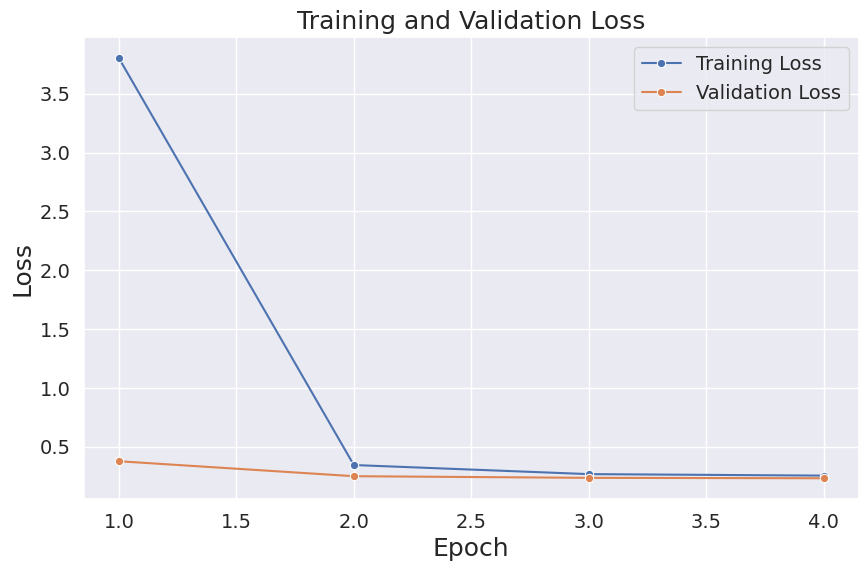

In [100]:
import seaborn as sns
### Plot Training & Validation Loss
data = {'Epoch': range(1, 5), 'Training Loss': train_losses, 'Validation Loss': val_losses}
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set(font_scale=1.5)

# Plot train & val loss
sns.lineplot(data=df, x="Epoch", y="Training Loss", label="Training Loss", marker='o')
sns.lineplot(data=df, x="Epoch", y="Validation Loss", label="Validation Loss", marker='o')

# set the axis labels and title
ax.set(xlabel='Epoch', ylabel='Loss')
ax.set_title('Training and Validation Loss', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)
# ax.grid(True, which='both', linestyle='--', color='lightgray')

In [101]:
torch.save(bart_model.state_dict(), 'models/bart_disentanglement.pth')
# download checkpoint file
# files.download('/content/drive/MyDrive/Colab Notebooks/models/bart_model2_checkpoint.pth')

In [34]:
# state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/models/bart_model2_checkpoint.pth')
# print(state_dict.keys())

## Model Evaluation on Test set  
In intial attempts we observed that generated text length was very varying in comparison to golden text. 
1.  Sometimes longer input sentences were losing the words during translation. 
2.  Small input sentences has longer translated sentences
3.  Smaller sentences has meaningless words added in the end ie context of the input sentence was gettung lost.

To address this, 
1. we adjusted the decoding parameters, such as the length penalty or the minimum and maximum length constraints, to encourage the model to generate appropriate length of text. We added length penalization of 2 to discourage longer generation of sentence without meaningful context. 
2. Instead of sampling only from the most likely K words, we ended up using Top-p sampling to choose from the smallest possible set of words whose cumulative probability exceeds the probability p. 
3. We set this value high inorder to get high probablistic word. 
4. We experimented with beam search size from 3-10 and observed that 5 gave us reasonble translated text

After fine tuning generate method,we observed that model started performing little well in case of short sentences.


In [102]:
test_data = MyDataset(test_path, MAX_SEQ_LEN,'test')
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,collate_fn=collate_fn)



 test  dataset preview .....
*******************************************
Input :: toxic        :: So maybe you should be more retarded.
Input :: masked toxic :: So maybe you should be more <mask>.
Input :: non toxic    :: So maybe you should be more backward
encoded length toxic : {'input_ids': [0, 2847, 2085, 47, 197, 28, 55, 47304, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [103]:
rouge = evaluate.load('rouge')
bleu = evaluate.load('bleu')


# Define a smoothing function for Rouge-L
smoothie = SmoothingFunction().method4

def model_evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    # Calculate the evaluation metrics
    total_correct = 0
    total_predicted = 0
    total_gold = 0
    total_batches = 0

    total_rouge1 = 0
    total_rouge2 = 0
    total_rougel = 0
    total_rougelsum = 0
    total_gen_len = 0

    golden_texts=[]
    predicted_generated_text=[]
    bleu_scores = []
    rouge = Rouge()
    with torch.no_grad():
        for batch in tqdm(data_loader):
            toxic_src = batch['toxic_ids'].cuda()
            non_toxic_tgt = batch['non_toxic_ids'].cuda()
            masked_toxic_src= batch['masked_toxic_ids'].cuda()
            
            generated_ids = bart_model.masked_encoder_decoder.generate(
                input_ids=masked_toxic_src.cuda(),
                # max_length=get_max_length(masked_toxic_src.cuda()),
                max_length=256,
                min_length=get_min_length(non_toxic_tgt.cuda()),
                num_beams=5,
                early_stopping=True,
                top_k=50, #50
                length_penalty=2, #1.2
                repetition_penalty=1,
                no_repeat_ngram_size=5,
                top_p = 0.95,
                temperature=0.8,
                decoder_start_token_id=bart_config.decoder_start_token_id
            )

            predicted_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            if len(predicted_text) == 0:
                predicted_text = "None"
            predicted_generated_text.extend(predicted_text)

            gold_text = tokenizer.batch_decode(non_toxic_tgt[:, 1:], skip_special_tokens=True)
            golden_texts.extend(gold_text)

            # calculating cross entropy loss
            outputs=bart_model(context_input_ids=toxic_src, masked_input_ids=masked_toxic_src, target_ids=non_toxic_tgt)
            loss = outputs.loss
            # loss = loss_fn(outputs, non_toxic_tgt.cuda())
            
            total_loss += loss.item()
            
            
            for i, (predicted_sent, gold_sent) in enumerate(zip(predicted_generated_text, golden_texts)):
                # Calculate the number of correct tokens
                
                correct_tokens = sum([1 for p, g in zip(predicted_sent, gold_sent) if p == g])
                total_correct += correct_tokens
                
                # Calculate the number of predicted and gold tokens
                predicted_tokens = len(predicted_sent)
                total_predicted += predicted_tokens
                
                gold_tokens = len(gold_sent.split())
                total_gold += gold_tokens
               
            # Calculate average generated length
            total_gen_len += sum([len(sent.split()) for sent in predicted_text])
            total_batches += 1*len(predicted_text)


    print('number of records in test',total_batches)     

    # Calculate average metrics for the entire dataset
    avg_loss = total_loss / total_batches
    avg_accuracy = total_correct / total_predicted if total_predicted > 0 else 0
    avg_precision = total_correct / total_predicted if total_predicted > 0 else 0
    avg_recall = total_correct / total_gold if total_gold > 0 else 0
    avg_f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall) if avg_precision + avg_recall > 0 else 0

    print("Loss: {:.4f}".format(avg_loss))
    print("Accuracy: {:.4f}".format(avg_accuracy))
    print("Precision: {:.4f}".format(avg_precision))
    print("Recall: {:.4f}".format(avg_recall))
    print("F1 Score: {:.4f}".format(avg_f1))

    return predicted_generated_text,golden_texts

predicted_generated_text,golden_texts=model_evaluate(bart_model, test_loader)


100%|███████████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.00s/it]

number of records in test 200
Loss: 0.0289
Accuracy: 0.2709
Precision: 0.2709
Recall: 1.7798
F1 Score: 0.4702


In [104]:
print(bleu.compute(predictions=predicted_generated_text,references=golden_texts))

{'bleu': 0.40839219475928473, 'precisions': [0.5323934206109433, 0.431090320259086, 0.3730127956572315, 0.324926439680538], 'brevity_penalty': 1.0, 'length_ratio': 1.299738219895288, 'translation_length': 2979, 'reference_length': 2292}


In [105]:
df_test=pd.read_csv(test_path,sep=",", header=None) 
# df_test = pd.read_csv('data/original-test.tsv', sep='\t')

for i in range(len(predicted_generated_text[:10])):
  print('\nOriginal text   :: ',df_test[1][i])
  print('Gold text       :: ',df_test[2][i])
  print('Translated text :: ',predicted_generated_text[i])

# Create a new DataFrame with the generated texts
df_gen = pd.DataFrame({'bart_tuning_output': predicted_generated_text}) 

# Add the generated_text column to the df_test dataframe
df_bart_output = pd.concat([df_test, df_gen], axis=1)

# Save the updated dataframe as a CSV file
df_bart_output=df_bart_output.drop([0],axis=1)
df_bart_output=df_bart_output[:-1]
df_bart_output.to_csv('outputs/bart_disentanglement.csv',sep='\t',index=False,header=['toxic_text','gold_text','bart_tuning_output'])


Original text   ::  So maybe you should be more retarded.
Gold text       ::  So maybe you should be more backward
Translated text ::  So maybe you should be more careful.

Original text   ::  THERES A MEGATHREAD FOR VACCINE OR COVID RELATED TOPICS. DON'T TALK ABOUT THAT SHIT HERE IDIOT!
Gold text       ::  THERES ACTUALLY A MEGATHREAD FOR VACCINE OR COVID RELATED TOPICS. DON'T TALK ABOUT THAT STUFF HERE!
Translated text ::  THERES A MEGATHREAD FOR VACCINE OR COLLABORATE RELATED TOPICS. DON'T TALK ABOUT THAT. CLICK HERE IDIOT!

Original text   ::  the fuck. you are on drugs
Gold text       ::  uh.. you are not being realistic
Translated text ::  the U.S. you are on drugs

Original text   ::  NTA. Dump his ass. Tablemanners are no rocket science. Treating other people like human beings is no rocket science. His still a child.
Gold text       ::  You should leave him. Tablemanners are no rocket science. Treating other people like human beings is no rocket science. His still a child.
Tra

In [106]:
# output_file = '/content/drive/MyDrive/Colab Notebooks/outputs/bart_tuning_output2.csv'
output_file = 'outputs/bart_disentanglement.csv'
df_finetune = pd.read_csv(output_file, sep="\t")
df_finetune

,toxic_text,gold_text,bart_tuning_output
0,So maybe you should be more retarded.,So maybe you should be more backward,So maybe you should be more careful.
1,THERES A MEGATHREAD FOR VACCINE OR COVID RELAT...,THERES ACTUALLY A MEGATHREAD FOR VACCINE OR CO...,THERES A MEGATHREAD FOR VACCINE OR COLLABORATE...
2,the fuck. you are on drugs,uh.. you are not being realistic,the U.S. you are on drugs
3,NTA. Dump his ass. Tablemanners are no rocket ...,You should leave him. Tablemanners are no rock...,NTA. He is still a child and his life is not r...
4,Youre soft as baby shit,Youre really soft,Youre soft as baby.
...,...,...,...
194,"NTA, Jesus your brother is dumb. How long did ...","NTA, your brother is not thinking straight. Ho...","""NTA is not a political party"
195,Formula onenascar.shit it exactly the same exc...,Formula onenascar.it exactly the same except t...,Formula onenascar.com calls it exactly the sam...
196,"BRB, gonna go call the mods pathetic egotistic...","BRB, gonna go call the mods.","""BRITAIN IS RESPONSIBLE"
197,CUCKOLD Carlson is a problem,Carlson is the problem,Tucker Carlson is a problem


In [107]:
print(rouge.compute(predictions=df_finetune['bart_tuning_output'],
              references=df_finetune['gold_text']))

{'rouge1': 0.5984567230870393, 'rouge2': 0.47918544423221626, 'rougeL': 0.5948542625757081, 'rougeLsum': 0.5960471426133374}


### Non Toxicity Score based on DistilBert classification model 

In [108]:
import sys
sys.path.append('./notebooks')
from DistilBertClassification import BertClassificationML, NonToxicScoreDataLoader, NonToxicScore

# Load DistilBERT Classification Model to calculate NonToxicScore
score_model = BertClassificationML()
score_model = score_model.to(device)

# Load training weights
pretrained_weights = torch.load('models/DistilBertToxicClassification7.pth')
score_model.load_state_dict(pretrained_weights )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [109]:
output_file = 'outputs/bart_disentanglement.csv'
output_col = 'bart_tuning_output'

# Create Data Loader
score_loader = NonToxicScoreDataLoader(output_file, output_col, max_length=256)

# Calculate NonToxicScore
bart_NonToxicScores, avg_score = NonToxicScore(score_loader, score_model)

{'NonToxicScore': 0.5730693882264561}


In [110]:
# Look at output texts with low NonToxicScore, or still classified as Toxic after Style Transfering
df_finetune['NonToxicScore'] = bart_NonToxicScores

df_finetune_lowscore = df_finetune[df_finetune['NonToxicScore'] < 0.5][['toxic_text', 'gold_text', 'bart_tuning_output', 'NonToxicScore']]
df_finetune_lowscore

,toxic_text,gold_text,bart_tuning_output,NonToxicScore
1,THERES A MEGATHREAD FOR VACCINE OR COVID RELAT...,THERES ACTUALLY A MEGATHREAD FOR VACCINE OR CO...,THERES A MEGATHREAD FOR VACCINE OR COLLABORATE...,0.001780
5,Because everyone knows why. Its jadas fault. W...,Because everyone knows it's jadas fault. Will ...,Because everyone knows why. Its jadas fault. W...,0.083680
6,And poor kids are just as bright as white kids...,He said poor kids are just as bright as white ...,And poor kids are just as bright as white kids...,0.070962
7,Tucker is a garbage person that no one will mi...,Tucker is a bad person who instigates racism,Tucker is a garbage person that no one will mi...,0.007579
10,Fuck off dude. Worst of the fucking worst!,Stop dude. Worst of the worst!,Hey dude. Worst of the worst of the worst!,0.450018
...,...,...,...,...
185,You mean that chick with a dick?,You mean that transgender woman?,You mean that chick with a gun?,0.039810
190,Youve been completely subverted yet here you a...,It's a little ironic that you've been subverte...,Youve been completely subverted yet here you a...,0.197244
191,I wish I could spit my unvaccinated saliva on ...,I wish I could weaponize my unvaccinated saliva.,I wish I could spit my unvaccinated saliva on ...,0.033816
195,Formula onenascar.shit it exactly the same exc...,Formula onenascar.it exactly the same except t...,Formula onenascar.com calls it exactly the sam...,0.002139


In [111]:
for i in range(len(df_finetune_lowscore)):
    print('\nToxic Text:', df_finetune_lowscore['toxic_text'].values[i])
    print('Style Transfer Text:', df_finetune_lowscore.bart_tuning_output.values[i])
    print('NonToxicScore:', df_finetune_lowscore.NonToxicScore.values[i])


Toxic Text: THERES A MEGATHREAD FOR VACCINE OR COVID RELATED TOPICS. DON'T TALK ABOUT THAT SHIT HERE IDIOT!
Style Transfer Text: THERES A MEGATHREAD FOR VACCINE OR COLLABORATE RELATED TOPICS. DON'T TALK ABOUT THAT. CLICK HERE IDIOT!
NonToxicScore: 0.001779827754944563

Toxic Text: Because everyone knows why. Its jadas fault. Will was just triggered because of all the shit he has to deal with because of her.
Style Transfer Text: Because everyone knows why. Its jadas fault. Will was just triggered because of all the shit he has to deal with because of her.
NonToxicScore: 0.0836801826953888

Toxic Text: And poor kids are just as bright as white kids. Your blundering bafoon chooses racism as well
Style Transfer Text: And poor kids are just as bright as white kids. Your blundering bafoon chooses racism as well
NonToxicScore: 0.07096169143915176

Toxic Text: Tucker is a garbage person that no one will miss when hes gone hes also a racist rublerouser
Style Transfer Text: Tucker is a garbage 